# Tensorflow data pipeline

This is an **intermediate level notebook** to explain the tensorflow data pipeline and feature engineering pipleline using a base model and a feature engineered model.

# *Import libraries*

In [1]:
import datetime
import logging
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd

from tensorflow import feature_column as fc
from tensorflow.keras import layers
from tensorflow.keras import models

In [2]:
df=pd.read_csv("/kaggle/input/new-york-city-taxi-fare-prediction/train.csv", nrows=1000)
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [3]:
# Define some column name variables for later use
CSV_COLUMNS = [
    'fare_amount',
    'pickup_datetime',
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'passenger_count',
    'key',
]
LABEL_COLUMN = 'fare_amount'
STRING_COLS = ['pickup_datetime']
NUMERIC_COLS = ['pickup_longitude', 'pickup_latitude',
                'dropoff_longitude', 'dropoff_latitude',
                'passenger_count']

In [4]:
df.isna().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [5]:
# Split df into features and label
features=df.drop(["key","fare_amount"], axis=1)
label=df["fare_amount"]

In [6]:
# Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(800, 6)
(200, 6)
(800,)
(200,)


# *Converting Pandas dataframe to tf.data dataset*

In [7]:
from random import shuffle

#Train dataset from pandas to tf dataframe
dataframe = X_train.copy()
labels = y_train
train_ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
train_ds=train_ds.shuffle(buffer_size=len(dataframe))
train_ds = train_ds.batch(batch_size=32)


In [8]:
dataframe = X_test.copy()
labels = y_test
test_ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
test_ds = test_ds.batch(batch_size=32)

# *Building DNN - Baseline model*

In [9]:
def rmse(y_true, y_pred):  # Root mean square error
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

In [10]:
def build_dnn_model():
    # input layer
    inputs = {
        colname: layers.Input(name=colname, shape=(), dtype='float32')
        for colname in NUMERIC_COLS
    }

    # feature_columns
    feature_columns = {
        colname: fc.numeric_column(colname)
        for colname in NUMERIC_COLS
    }

    # Constructor for DenseFeatures takes a list of numeric columns
    dnn_inputs = layers.DenseFeatures(feature_columns.values())(inputs)
    h1 = layers.Dense(32, activation='relu', name='h1')(dnn_inputs)
    h2 = layers.Dense(8, activation='relu', name='h2')(h1)
    output = layers.Dense(1, activation='linear', name='fare')(h2)
    model = models.Model(inputs, output)

    # compile model
    model.compile(optimizer='adam', loss='mse', metrics=[rmse,'mse'])

    return model

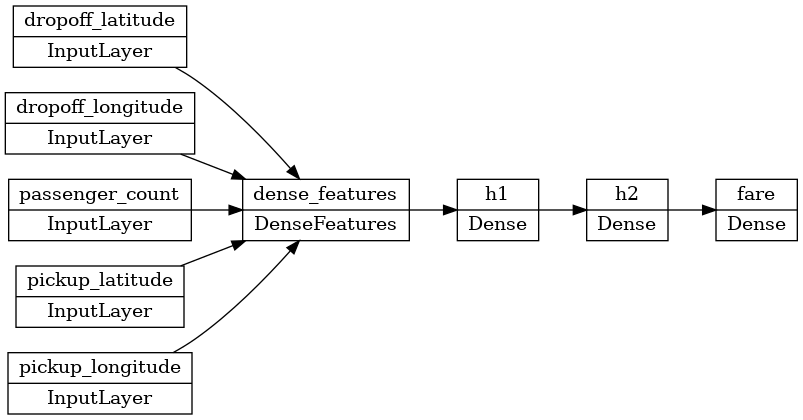

In [11]:
model = build_dnn_model()

# Visualize the DNN 
tf.keras.utils.plot_model(model, 'dnn_model.png', show_shapes=False, rankdir='LR')

In [12]:
history = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=20)

Epoch 1/20


/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['pickup_datetime'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


25/25 [==============================] - 2s 14ms/step - loss: 105.6407 - rmse: 9.9670 - mse: 105.6407 - val_loss: 71.5982 - val_rmse: 8.0071 - val_mse: 71.5982
Epoch 2/20
25/25 [==============================] - 0s 3ms/step - loss: 98.5533 - rmse: 9.5681 - mse: 98.5533 - val_loss: 71.2907 - val_rmse: 7.9828 - val_mse: 71.2907
Epoch 3/20
25/25 [==============================] - 0s 4ms/step - loss: 97.7158 - rmse: 9.6685 - mse: 97.7158 - val_loss: 70.2323 - val_rmse: 7.8881 - val_mse: 70.2323
Epoch 4/20
25/25 [==============================] - 0s 4ms/step - loss: 97.4307 - rmse: 9.5509 - mse: 97.4307 - val_loss: 71.4389 - val_rmse: 7.9982 - val_mse: 71.4389
Epoch 5/20
25/25 [==============================] - 0s 4ms/step - loss: 97.8749 - rmse: 9.5699 - mse: 97.8749 - val_loss: 70.8942 - val_rmse: 7.9545 - val_mse: 70.8942
Epoch 6/20
25/25 [==============================] - 0s 4ms/step - loss: 98.5001 - rmse: 9.6224 - mse: 98.5001 - val_loss: 69.9145 - val_rmse: 7.8626 - val_mse: 69.9145


In [13]:
# Plotting MSE and loss
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))

    for idx, key in enumerate(metrics):  
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history['val_{}'.format(key)])
        plt.title('model {}'.format(key))
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left');    

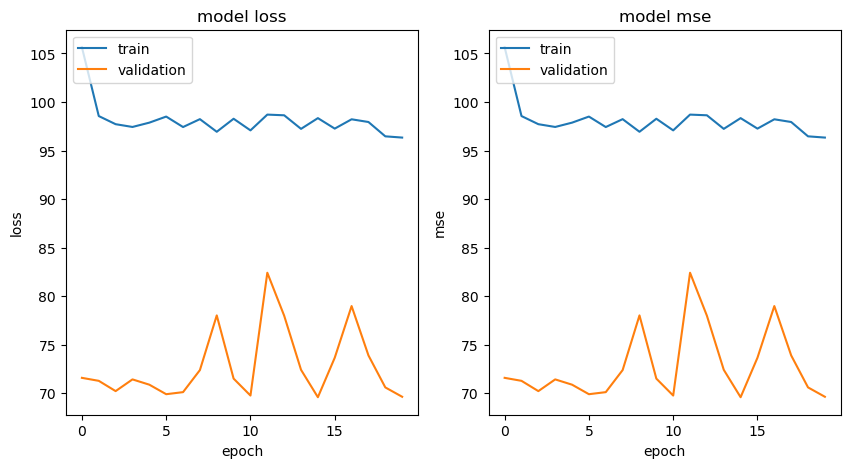

In [14]:
plot_curves(history, ['loss', 'mse'])

In [15]:
# Use the model to do prediction with `model.predict()`.
model.predict({
    'pickup_longitude': tf.convert_to_tensor([-73.982683]),
    'pickup_latitude': tf.convert_to_tensor([40.742104]),
    'dropoff_longitude': tf.convert_to_tensor([-73.983766]),
    'dropoff_latitude': tf.convert_to_tensor([40.755174]),
    'passenger_count': tf.convert_to_tensor([3.0]),
    'pickup_datetime': tf.convert_to_tensor(['2010-02-08 09:17:00 UTC'], dtype=tf.string),
}, steps=1)

1/1 [==============================] - 0s 180ms/step


array([[11.37914]], dtype=float32)

# Feature engineering using Tensorflow


In [16]:
# Transforming "pickup_datetime" which is currently of the format : 2009-06-15 17:26:21 UTC
def parse_datetime(s):
    if type(s) is not str:
        s = s.numpy().decode('utf-8')
    return datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S %Z")


DAYS = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
def get_dayofweek(s):
    ts = parse_datetime(s)
    return DAYS[ts.weekday()]

@tf.function
def dayofweek(ts_in):
    return tf.map_fn(
        lambda s: tf.py_function(get_dayofweek, inp=[s], Tout=tf.string),
        ts_in)

In [17]:
df["pickup_datetime"][0]

'2009-06-15 17:26:21 UTC'

In [18]:
# Transforming latitudes and longitudes
def euclidean(params):
    lon1, lat1, lon2, lat2 = params
    londiff = lon2 - lon1
    latdiff = lat2 - lat1
    return tf.sqrt(londiff*londiff + latdiff*latdiff)

def scale_longitude(lon_column):
    return (lon_column + 78)/8.
def scale_latitude(lat_column):
    return (lat_column - 37)/8.

In [19]:
# Combining all transformations
def transform(inputs, numeric_cols, string_cols, nbuckets):
    print("Inputs before features transformation: {}".format(inputs.keys()))

    # Pass-through columns
    transformed = inputs.copy()
    del transformed['pickup_datetime']

    feature_columns = {
        colname: tf.feature_column.numeric_column(colname)
        for colname in numeric_cols
    }

    # Scaling longitude from range [-70, -78] to [0, 1]
    for lon_col in ['pickup_longitude', 'dropoff_longitude']:
        transformed[lon_col] = layers.Lambda(
            scale_longitude,
            name="scale_{}".format(lon_col))(inputs[lon_col])

    # Scaling latitude from range [37, 45] to [0, 1]
    for lat_col in ['pickup_latitude', 'dropoff_latitude']:
        transformed[lat_col] = layers.Lambda(
            scale_latitude,
            name='scale_{}'.format(lat_col))(inputs[lat_col])

    # add Euclidean distance
    transformed['euclidean'] = layers.Lambda(
        euclidean,
        name='euclidean')([inputs['pickup_longitude'],
                           inputs['pickup_latitude'],
                           inputs['dropoff_longitude'],
                           inputs['dropoff_latitude']])
    feature_columns['euclidean'] = fc.numeric_column('euclidean')

    # create bucketized features
    latbuckets = np.linspace(0, 1, nbuckets).tolist()
    lonbuckets = np.linspace(0, 1, nbuckets).tolist()
    b_plat = fc.bucketized_column(feature_columns['pickup_latitude'], latbuckets)
    b_dlat = fc.bucketized_column(feature_columns['dropoff_latitude'], latbuckets)
    b_plon = fc.bucketized_column(feature_columns['pickup_longitude'], lonbuckets)
    b_dlon = fc.bucketized_column(feature_columns['dropoff_longitude'], lonbuckets)

    # create crossed columns
    ploc = fc.crossed_column([b_plat, b_plon], nbuckets * nbuckets)
    dloc = fc.crossed_column([b_dlat, b_dlon], nbuckets * nbuckets)
    pd_pair = fc.crossed_column([ploc, dloc], nbuckets ** 4)

    # create embedding columns
    feature_columns['pickup_and_dropoff'] = fc.embedding_column(pd_pair, 100)

    print("Transformed features: {}".format(transformed.keys()))
    print("Feature columns: {}".format(feature_columns.keys()))
    return transformed, feature_columns

# *DNN using the feature engineered columns*

In [20]:
NBUCKETS = 10

def build_feature_engg_dnn_model():
    # input layer is all float except for pickup_datetime which is a string
    inputs = {
        colname: layers.Input(name=colname, shape=(), dtype='float32')
        for colname in NUMERIC_COLS
    }
    inputs.update({
        colname: tf.keras.layers.Input(name=colname, shape=(), dtype='string')
        for colname in STRING_COLS
    })

    # transforms
    transformed, feature_columns = transform(inputs,
                                             numeric_cols=NUMERIC_COLS,
                                             string_cols=STRING_COLS,
                                             nbuckets=NBUCKETS)
    dnn_inputs = layers.DenseFeatures(feature_columns.values())(transformed)

    # two hidden layers of [32, 8] just in like the BQML DNN
    h1 = layers.Dense(32, activation='relu', name='h1')(dnn_inputs)
    h2 = layers.Dense(8, activation='relu', name='h2')(h1)

    # final output is a linear activation because this is regression
    output = layers.Dense(1, activation='linear', name='fare')(h2)
    model = models.Model(inputs, output)

    # Compile model
    model.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mse'])
    return model

In [21]:
feature_model = build_feature_engg_dnn_model()

Inputs before features transformation: dict_keys(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'pickup_datetime'])
Transformed features: dict_keys(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'euclidean'])
Feature columns: dict_keys(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'euclidean', 'pickup_and_dropoff'])


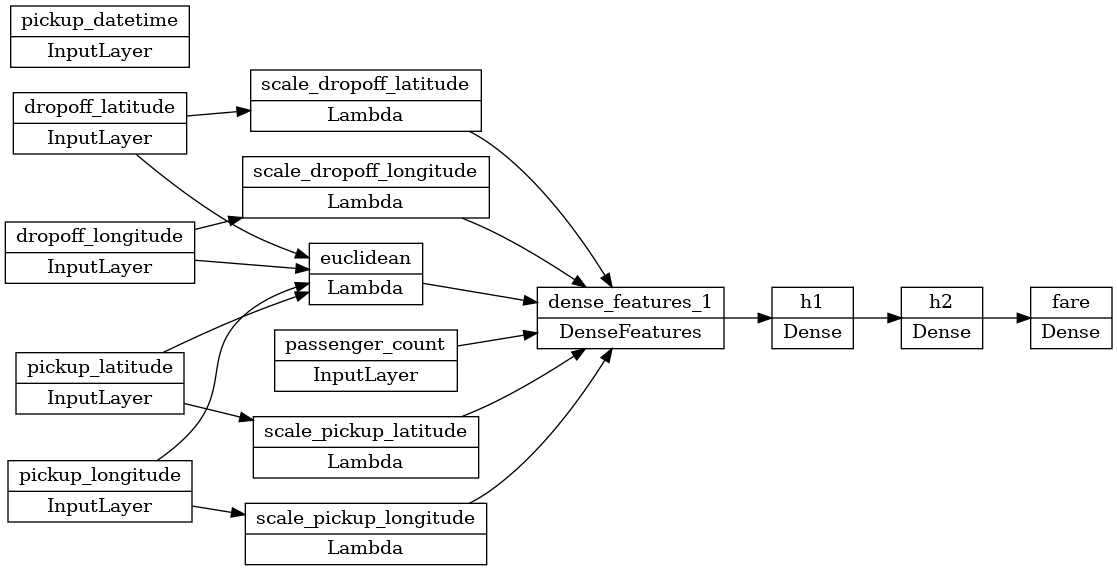

In [22]:
# We can visualize the DNN using the Keras `plot_model` utility.
tf.keras.utils.plot_model(feature_model, 'dnn_model_engineered.png', show_shapes=False, rankdir='LR')

In [23]:
history = feature_model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=20)

Epoch 1/20
25/25 [==============================] - 3s 39ms/step - loss: 217.1817 - rmse: 14.3946 - mse: 217.1817 - val_loss: 155.1058 - val_rmse: 12.0241 - val_mse: 155.1058
Epoch 2/20
25/25 [==============================] - 0s 18ms/step - loss: 188.8597 - rmse: 13.5210 - mse: 188.8597 - val_loss: 124.8049 - val_rmse: 10.7070 - val_mse: 124.8049
Epoch 3/20
25/25 [==============================] - 0s 16ms/step - loss: 147.2066 - rmse: 11.9202 - mse: 147.2066 - val_loss: 85.2896 - val_rmse: 8.6936 - val_mse: 85.2896
Epoch 4/20
25/25 [==============================] - 0s 15ms/step - loss: 107.0950 - rmse: 9.9016 - mse: 107.0950 - val_loss: 69.3523 - val_rmse: 7.8242 - val_mse: 69.3523
Epoch 5/20
25/25 [==============================] - 0s 15ms/step - loss: 95.8153 - rmse: 9.4954 - mse: 95.8153 - val_loss: 71.8772 - val_rmse: 8.0394 - val_mse: 71.8772
Epoch 6/20
25/25 [==============================] - 0s 16ms/step - loss: 95.7605 - rmse: 9.3013 - mse: 95.7605 - val_loss: 70.4558 - val_r

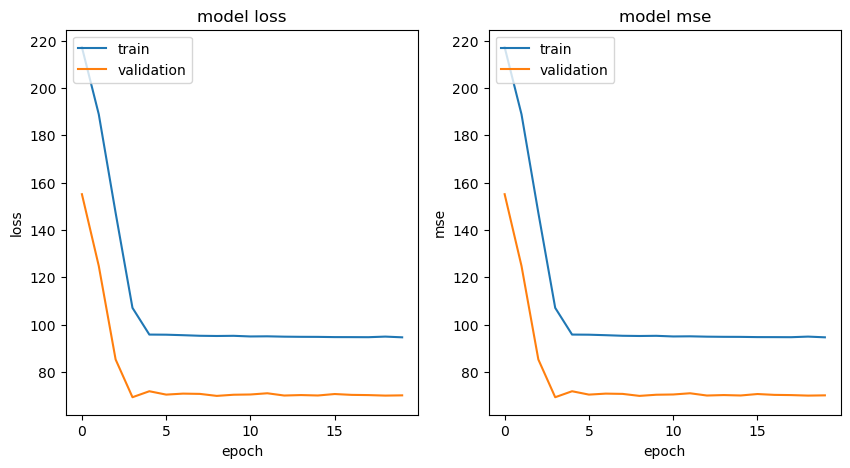

In [24]:
plot_curves(history, ['loss', 'mse'])

In [25]:
# Use the model to do prediction with `model.predict()`.
feature_model.predict({
    'pickup_longitude': tf.convert_to_tensor([-73.982683]),
    'pickup_latitude': tf.convert_to_tensor([40.742104]),
    'dropoff_longitude': tf.convert_to_tensor([-73.983766]),
    'dropoff_latitude': tf.convert_to_tensor([40.755174]),
    'passenger_count': tf.convert_to_tensor([3.0]),
    'pickup_datetime': tf.convert_to_tensor(['2010-02-08 09:17:00 UTC'], dtype=tf.string),
}, steps=1)

1/1 [==============================] - 0s 356ms/step


array([[12.262246]], dtype=float32)